In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100

In [3]:
#CREATE DATASET

dataset = torch.load("mask_unet_dataset.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

num_classes = 2
model = Unet(
    encoder_name="resnet34",
    in_channels=16,
    classes=num_classes
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
model = model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [6]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader):
    model.train()
    train_loss = correct = total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += labels.numel()

    #total is number of train instances
    avg_loss = train_loss/len(train_loader)
    accuracy = correct/total
    return avg_loss, accuracy

def eval(model, val_loader):
    model.eval()
    val_loss = correct = total = 0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        loss = criterion(outputs, labels)

        val_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += labels.numel()

    avg_loss = val_loss/len(val_loader)
    accuracy = correct/total
    return avg_loss, accuracy

In [7]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = eval(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch: {e} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

100%|██████████| 47/47 [00:14<00:00,  3.30it/s]


Epoch: 1 | Train Loss: 0.8147 | Train Acc: 0.4325 | Val Loss: 0.7326 | Val Acc: 0.4978


100%|██████████| 47/47 [00:12<00:00,  3.89it/s]


Epoch: 2 | Train Loss: 0.6393 | Train Acc: 0.6216 | Val Loss: 0.5904 | Val Acc: 0.6810


100%|██████████| 47/47 [00:15<00:00,  2.97it/s]


Epoch: 3 | Train Loss: 0.5490 | Train Acc: 0.7562 | Val Loss: 0.5161 | Val Acc: 0.7788


100%|██████████| 47/47 [00:14<00:00,  3.25it/s]


Epoch: 4 | Train Loss: 0.4861 | Train Acc: 0.8321 | Val Loss: 0.4505 | Val Acc: 0.8504


100%|██████████| 47/47 [00:15<00:00,  3.11it/s]


Epoch: 5 | Train Loss: 0.4414 | Train Acc: 0.8711 | Val Loss: 0.4071 | Val Acc: 0.8892


100%|██████████| 47/47 [00:15<00:00,  3.00it/s]


Epoch: 6 | Train Loss: 0.4096 | Train Acc: 0.8933 | Val Loss: 0.3927 | Val Acc: 0.8963


100%|██████████| 47/47 [00:15<00:00,  3.05it/s]


Epoch: 7 | Train Loss: 0.3858 | Train Acc: 0.9070 | Val Loss: 0.4014 | Val Acc: 0.8949


100%|██████████| 47/47 [00:15<00:00,  3.10it/s]


Epoch: 8 | Train Loss: 0.3663 | Train Acc: 0.9153 | Val Loss: 0.3877 | Val Acc: 0.9056


100%|██████████| 47/47 [00:15<00:00,  3.12it/s]


Epoch: 9 | Train Loss: 0.3494 | Train Acc: 0.9215 | Val Loss: 0.3494 | Val Acc: 0.9134


100%|██████████| 47/47 [00:15<00:00,  3.13it/s]


Epoch: 10 | Train Loss: 0.3348 | Train Acc: 0.9254 | Val Loss: 0.3300 | Val Acc: 0.9228


100%|██████████| 47/47 [00:15<00:00,  2.98it/s]


Epoch: 11 | Train Loss: 0.3218 | Train Acc: 0.9286 | Val Loss: 0.3307 | Val Acc: 0.9206


100%|██████████| 47/47 [00:12<00:00,  3.80it/s]


Epoch: 12 | Train Loss: 0.3100 | Train Acc: 0.9315 | Val Loss: 0.3593 | Val Acc: 0.9032


100%|██████████| 47/47 [00:49<00:00,  1.05s/it]


Epoch: 13 | Train Loss: 0.2999 | Train Acc: 0.9331 | Val Loss: 0.3099 | Val Acc: 0.9230


100%|██████████| 47/47 [00:15<00:00,  2.95it/s]


Epoch: 14 | Train Loss: 0.2890 | Train Acc: 0.9358 | Val Loss: 0.3028 | Val Acc: 0.9232


100%|██████████| 47/47 [00:13<00:00,  3.56it/s]


Epoch: 15 | Train Loss: 0.2799 | Train Acc: 0.9377 | Val Loss: 0.2836 | Val Acc: 0.9319


100%|██████████| 47/47 [00:11<00:00,  4.27it/s]


Epoch: 16 | Train Loss: 0.2708 | Train Acc: 0.9395 | Val Loss: 0.2779 | Val Acc: 0.9322


100%|██████████| 47/47 [00:10<00:00,  4.28it/s]


Epoch: 17 | Train Loss: 0.2627 | Train Acc: 0.9409 | Val Loss: 0.3277 | Val Acc: 0.9116


100%|██████████| 47/47 [00:11<00:00,  4.17it/s]


Epoch: 18 | Train Loss: 0.2551 | Train Acc: 0.9426 | Val Loss: 0.2583 | Val Acc: 0.9360


100%|██████████| 47/47 [00:12<00:00,  3.80it/s]


Epoch: 19 | Train Loss: 0.2471 | Train Acc: 0.9440 | Val Loss: 0.2615 | Val Acc: 0.9319


100%|██████████| 47/47 [00:13<00:00,  3.45it/s]


Epoch: 20 | Train Loss: 0.2411 | Train Acc: 0.9447 | Val Loss: 0.2520 | Val Acc: 0.9365


100%|██████████| 47/47 [00:11<00:00,  4.07it/s]


Epoch: 21 | Train Loss: 0.2341 | Train Acc: 0.9459 | Val Loss: 0.2498 | Val Acc: 0.9361


100%|██████████| 47/47 [00:12<00:00,  3.69it/s]


Epoch: 22 | Train Loss: 0.2282 | Train Acc: 0.9468 | Val Loss: 0.2361 | Val Acc: 0.9384


100%|██████████| 47/47 [00:12<00:00,  3.64it/s]


Epoch: 23 | Train Loss: 0.2220 | Train Acc: 0.9477 | Val Loss: 0.2320 | Val Acc: 0.9391


100%|██████████| 47/47 [00:11<00:00,  4.01it/s]


Epoch: 24 | Train Loss: 0.2162 | Train Acc: 0.9488 | Val Loss: 0.2272 | Val Acc: 0.9407


100%|██████████| 47/47 [00:12<00:00,  3.92it/s]


Epoch: 25 | Train Loss: 0.2109 | Train Acc: 0.9494 | Val Loss: 0.2228 | Val Acc: 0.9404


100%|██████████| 47/47 [00:12<00:00,  3.75it/s]


Epoch: 26 | Train Loss: 0.2060 | Train Acc: 0.9499 | Val Loss: 0.2238 | Val Acc: 0.9372


100%|██████████| 47/47 [00:11<00:00,  4.04it/s]


Epoch: 27 | Train Loss: 0.2012 | Train Acc: 0.9506 | Val Loss: 0.2174 | Val Acc: 0.9386


100%|██████████| 47/47 [00:11<00:00,  4.24it/s]


Epoch: 28 | Train Loss: 0.1966 | Train Acc: 0.9512 | Val Loss: 0.2085 | Val Acc: 0.9431


100%|██████████| 47/47 [00:10<00:00,  4.29it/s]


Epoch: 29 | Train Loss: 0.1917 | Train Acc: 0.9522 | Val Loss: 0.2059 | Val Acc: 0.9428


100%|██████████| 47/47 [00:11<00:00,  4.21it/s]


Epoch: 30 | Train Loss: 0.1883 | Train Acc: 0.9523 | Val Loss: 0.2032 | Val Acc: 0.9426


100%|██████████| 47/47 [00:12<00:00,  3.89it/s]


Epoch: 31 | Train Loss: 0.1839 | Train Acc: 0.9530 | Val Loss: 0.2022 | Val Acc: 0.9418


100%|██████████| 47/47 [00:14<00:00,  3.32it/s]


Epoch: 32 | Train Loss: 0.1801 | Train Acc: 0.9536 | Val Loss: 0.1976 | Val Acc: 0.9431


100%|██████████| 47/47 [00:11<00:00,  4.06it/s]


Epoch: 33 | Train Loss: 0.1773 | Train Acc: 0.9537 | Val Loss: 0.1948 | Val Acc: 0.9433


100%|██████████| 47/47 [00:10<00:00,  4.28it/s]


Epoch: 34 | Train Loss: 0.1726 | Train Acc: 0.9548 | Val Loss: 0.2034 | Val Acc: 0.9399


100%|██████████| 47/47 [00:10<00:00,  4.30it/s]


Epoch: 35 | Train Loss: 0.1698 | Train Acc: 0.9548 | Val Loss: 0.1888 | Val Acc: 0.9446


100%|██████████| 47/47 [00:11<00:00,  4.24it/s]


Epoch: 36 | Train Loss: 0.1664 | Train Acc: 0.9554 | Val Loss: 0.1912 | Val Acc: 0.9443


100%|██████████| 47/47 [00:11<00:00,  4.24it/s]


Epoch: 37 | Train Loss: 0.1640 | Train Acc: 0.9555 | Val Loss: 0.1983 | Val Acc: 0.9403


100%|██████████| 47/47 [00:11<00:00,  4.23it/s]


Epoch: 38 | Train Loss: 0.1602 | Train Acc: 0.9563 | Val Loss: 0.1983 | Val Acc: 0.9386


100%|██████████| 47/47 [00:11<00:00,  3.97it/s]


Epoch: 39 | Train Loss: 0.1579 | Train Acc: 0.9564 | Val Loss: 0.1774 | Val Acc: 0.9451


100%|██████████| 47/47 [00:12<00:00,  3.80it/s]


Epoch: 40 | Train Loss: 0.1560 | Train Acc: 0.9564 | Val Loss: 0.1797 | Val Acc: 0.9436


100%|██████████| 47/47 [00:12<00:00,  3.88it/s]


Epoch: 41 | Train Loss: 0.1531 | Train Acc: 0.9568 | Val Loss: 0.1828 | Val Acc: 0.9436


100%|██████████| 47/47 [00:11<00:00,  4.25it/s]


Epoch: 42 | Train Loss: 0.1498 | Train Acc: 0.9576 | Val Loss: 0.1933 | Val Acc: 0.9392


100%|██████████| 47/47 [00:10<00:00,  4.31it/s]


Epoch: 43 | Train Loss: 0.1479 | Train Acc: 0.9576 | Val Loss: 0.1675 | Val Acc: 0.9472


100%|██████████| 47/47 [00:11<00:00,  4.16it/s]


Epoch: 44 | Train Loss: 0.1454 | Train Acc: 0.9579 | Val Loss: 0.1705 | Val Acc: 0.9451


100%|██████████| 47/47 [00:11<00:00,  3.95it/s]


Epoch: 45 | Train Loss: 0.1427 | Train Acc: 0.9585 | Val Loss: 0.1668 | Val Acc: 0.9468


100%|██████████| 47/47 [00:13<00:00,  3.60it/s]


Epoch: 46 | Train Loss: 0.1405 | Train Acc: 0.9588 | Val Loss: 0.1668 | Val Acc: 0.9465


100%|██████████| 47/47 [00:11<00:00,  4.18it/s]


Epoch: 47 | Train Loss: 0.1395 | Train Acc: 0.9585 | Val Loss: 0.1658 | Val Acc: 0.9461


100%|██████████| 47/47 [00:10<00:00,  4.30it/s]


Epoch: 48 | Train Loss: 0.1362 | Train Acc: 0.9595 | Val Loss: 0.1690 | Val Acc: 0.9443


100%|██████████| 47/47 [00:10<00:00,  4.30it/s]


Epoch: 49 | Train Loss: 0.1350 | Train Acc: 0.9593 | Val Loss: 0.1570 | Val Acc: 0.9484


100%|██████████| 47/47 [00:10<00:00,  4.30it/s]


Epoch: 50 | Train Loss: 0.1325 | Train Acc: 0.9598 | Val Loss: 0.1678 | Val Acc: 0.9444


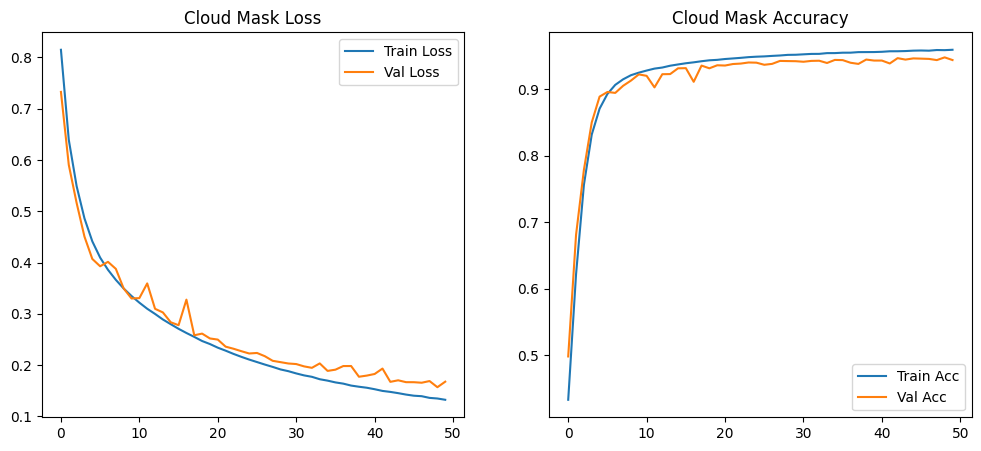

In [8]:
#PLOT LOSS and ACCURACY

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Cloud Mask Accuracy')
plt.legend()

plt.savefig("./graphs/unet_cloud_mask.png")  

plt.show()

In [9]:
#MODEL EVALUATION

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])


report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

print("REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted:", np.mean(iou))
print("Weighted:", np.average(iou, weights=supports))

100%|██████████| 12/12 [00:01<00:00,  9.55it/s]


REPORT:
               precision    recall  f1-score   support

           0      0.924     0.906     0.914   5803166
           1      0.971     0.977     0.974  18740066

    accuracy                          0.960  24543232
   macro avg      0.947     0.941     0.944  24543232
weighted avg      0.960     0.960     0.960  24543232

CONFUSION MATRIX:
 [[ 5255067   548099]
 [  435274 18304792]]

IOU: [0.84236877 0.94901677]
Unweighted: 0.8956927664020939
Weighted: 0.9238002002668984
